In [37]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import yaml
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve, auc
from pyedflib import highlevel
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [38]:
# Примерная функция для нормализации
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)


# Класс для подготовки датасета
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.fixed_length = 5000  # Пример длины для padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Берем данные пациента
        ecg_signal = self.data[idx]

        # Применяем нормализацию к каждому каналу
        ecg_signal = np.array([normalize(ch) for ch in ecg_signal])

        # Padding/Truncation до фиксированной длины
        ecg_signal = self._fix_length(ecg_signal)

        # Преобразование в torch.tensor
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return ecg_signal, label

    def _fix_length(self, ecg_signal):
        # Применяем padding или обрезание
        if ecg_signal.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - ecg_signal.shape[1]
            ecg_signal = np.pad(ecg_signal, ((0, 0), (0, pad_size)), "constant")
        else:
            ecg_signal = ecg_signal[:, : self.fixed_length]
        return ecg_signal


def create_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(labels), replacement=True
    )
    return sampler


class MultiBranchECGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3):
        super(MultiBranchECGNet, self).__init__()

        # Ветви для каждого канала (CNN)
        self.branches = nn.ModuleList(
            [self.create_branch() for _ in range(num_channels)]
        )

        # Attention слой для агрегации информации между каналами
        self.attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )

        # Линейный слой для выравнивания размерности перед attention
        self.linear_attn = nn.Linear(num_channels * 128, 128)

        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(p=config["model"]["parameters"]["dropout_rate"])

    def create_branch(self):
        """Создаем сверточную ветвь для каждого канала"""
        branch = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),  # Свертка с padding
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # Вторая сверточная операция
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  # Третья сверточная операция
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        return branch

    def forward(self, x):
        # x shape: [batch_size, num_channels, seq_len]

        # Обрабатываем каждый канал через свою ветвь (CNN для каждого канала)
        branch_outputs = []
        for i in range(x.size(1)):  # num_channels
            branch_output = self.branches[i](
                x[:, i : i + 1, :]
            )  # Обрабатываем i-й канал, [batch_size, 1, seq_len]
            branch_outputs.append(branch_output)

        # Объединяем выходы ветвей
        out = torch.stack(
            branch_outputs, dim=1
        )  # [batch_size, num_channels, 128, reduced_seq_len]

        # out = out.mean(dim=-1)  # Усредняем по временной оси: [batch_size, num_channels, 128]

        # # Применяем multi-head attention для межканальной агрегации
        # out, _ = self.attention(out, out, out)  # [batch_size, num_channels, 128]

        # # Flatten the output
        # out = torch.flatten(out, start_dim=1, end_dim=2)  # [batch_size, num_channels * 128]

        # Меняем форму, чтобы соответствовать входу MultiheadAttention: [batch_size, reduced_seq_len, num_channels * 128]
        batch_size, num_channels, embed_dim, seq_len = out.shape
        out = out.permute(0, 3, 1, 2).reshape(batch_size, seq_len, -1)

        out = F.relu(self.linear_attn(out))

        # Применяем Multihead Attention ко всей последовательности
        out, _ = self.attention(
            out, out, out
        )  # [batch_size, seq_len, num_channels * 128]

        # Усредняем по временной оси
        out = out.mean(dim=1)  # [batch_size, num_channels * 128]

        # Полносвязные слои для классификации
        out = F.relu(self.drop(self.fc1(out)))
        out = self.fc2(out)  # [batch_size, num_classes]
        return out

In [39]:
def validate_model(model, dataloader, chkpt):
    model = MultiBranchECGNet(num_channels=8, num_classes=2)
    model.load_state_dict(torch.load(chkpt, weights_only=True))
    model.eval()  # Переводим модель в режим оценки
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем градиенты для валидации
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Предсказания с максимальной вероятностью
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Преобразуем в numpy массивы
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Считаем accuracy
    recall = recall_score(all_labels, all_preds)
    print(f"Validation recall: {recall:.4f}")
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation accuracy: {accuracy:.4f}")
    precision = precision_score(all_labels, all_preds)
    print(f"Validation precision: {precision:.4f}")

    class_names = ["Норм. ритм", "Фракция снижена"]

    print("\n clasification report:\n", classification_report(all_labels, all_preds))

    print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix(all_labels, all_preds), display_labels=class_names
    )
    disp.plot(cmap="Blues", ax=ax)

    return all_preds

In [77]:
import pickle


def calculate(train_int, test_int, chkpt, verbose=False):
    # code to calculate the result
    data_root = Path("../../../Data/dumped/")
    with open(
        (data_root / f"X_train_fraction_train_{train_int}.pkl").resolve().__str__(),
        "rb",
    ) as f:
        f.seek(0)
        X_train = pickle.load(f)
    with open(
        (data_root / f"y_train_fraction_train_{train_int}.pkl").resolve().__str__(),
        "rb",
    ) as f:
        f.seek(0)
        y_train = pickle.load(f)
    with open(
        (data_root / f"X_test_fraction_test_{test_int}.pkl").resolve().__str__(), "rb"
    ) as f:
        f.seek(0)
        X_test = pickle.load(f)
    with open(
        (data_root / f"y_test_fraction_test_{test_int}.pkl").resolve().__str__(), "rb"
    ) as f:
        f.seek(0)
        y_test = pickle.load(f)

    if verbose:
        print(X_train.shape)
        print(y_train.shape)
    y_train = np.concatenate([y_train, y_train], axis=0)
    Y_train = y_train[0].astype("int8")
    Y_test = y_test[0].astype("int8")

    sampler = None
    train_dataset = ECGDataset(data=X_train, labels=Y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    # train_loader = DataLoader(train_dataset, batch_size=32)

    test_dataset = ECGDataset(data=X_test, labels=Y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    with open("./config.yaml", "r") as f:
        config = yaml.safe_load(f)

    model = MultiBranchECGNet(num_channels=8, num_classes=2)
    if verbose:
        inputs = X_test[0]
        plt.plot(inputs[0])

    with open(
        (data_root / f"test_itoname_test_{test_int}.json").resolve().__str__()
    ) as f:
        itoname_test = json.load(f)
        if verbose:
            print(itoname_test)
    with open(
        (data_root / f"train_itoname_train_{train_int}.json").resolve().__str__()
    ) as f:
        itoname_train = json.load(f)
        if verbose:
            print(itoname_train)

    path_prefix = Path("../../../Data") / "EF_11k_approx" / "extracted" / "edf_files"
    signals, signal_headers, _ = highlevel.read_edf(
        (path_prefix / itoname_test[str(0)]).resolve().__str__()
    )
    orig_value = signals[0][:5000]
    if verbose:
        plt.plot(orig_value)

    # Пример вызова валидации
    all_preds = validate_model(model, test_loader, chkpt=chkpt)
    return all_preds, y_test[0], itoname_test

(908, 8, 5000)
(2, 908)
{'0': 'TG9127.edf', '1': 'TG9076.edf', '2': 'TG778.edf', '3': 'TG10338.edf', '4': 'TG2361.edf', '5': 'TG6885.edf', '6': 'TG885.edf', '7': 'TG4268.edf', '8': 'TG864.edf', '9': 'TG536.edf', '10': 'TG7986.edf', '11': 'TG10229.edf', '12': 'TG6575.edf', '13': 'TG6802.edf', '14': 'TG7625.edf', '15': 'TG467.edf', '16': 'TG684.edf', '17': 'TG1855.edf', '18': 'TG2634.edf', '19': 'TG6344.edf', '20': 'TG50.edf', '21': 'TG1061.edf', '22': 'TG93.edf', '23': 'TG4166.edf', '24': 'TG3723.edf', '25': 'TG2030.edf', '26': 'TG10650.edf', '27': 'TG6536.edf', '28': 'TG5317.edf', '29': 'TG10768.edf', '30': 'TG9018.edf', '31': 'TG6236.edf', '32': 'TG4605.edf', '33': 'TG9333.edf', '34': 'TG9241.edf', '35': 'TG3520.edf', '36': 'TG4898.edf', '37': 'TG3615.edf', '38': 'TG3944.edf', '39': 'TG2954.edf', '40': 'TG5710.edf', '41': 'TG10662.edf', '42': 'TG10038.edf', '43': 'TG8109.edf', '44': 'TG9301.edf', '45': 'TG5203.edf', '46': 'TG1063.edf', '47': 'TG10174.edf', '48': 'TG4492.edf', '49': 'T

(array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

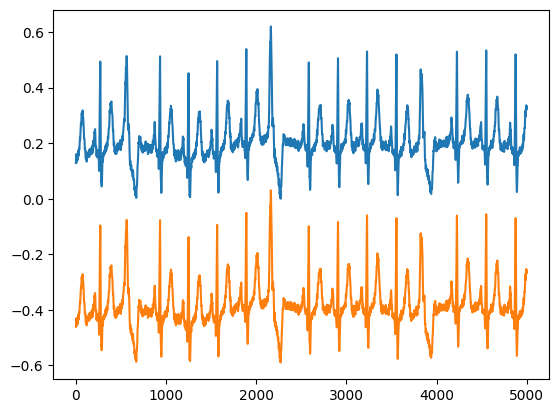

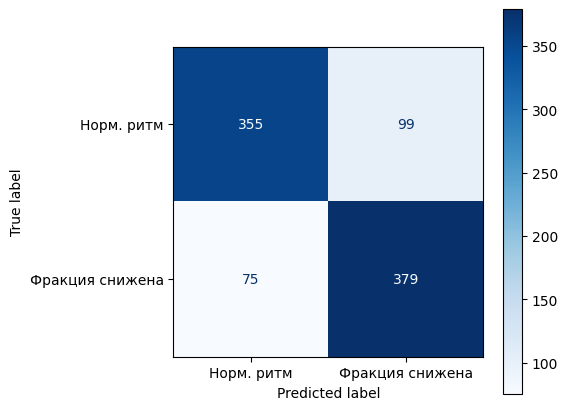

In [78]:
calculate(2, 2, "checkpoints/train_2.pth", verbose=True)

## Nice. Metadata corresponds with files!

Validation recall: 0.5242
Validation accuracy: 0.9250
Validation precision: 0.5574

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4944
           1       0.56      0.52      0.54       454

    accuracy                           0.92      5398
   macro avg       0.76      0.74      0.75      5398
weighted avg       0.92      0.92      0.92      5398

Матрица несоответствий для тестовой выборки метода ЛДА:



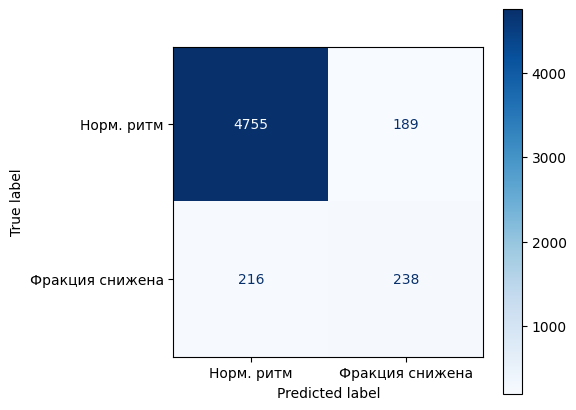

In [79]:
import pandas as pd

# all_filenames = [
#     x["filename"].relative_to("/home/kravchenko.artem/Projects/Diplomas").__str__()
#     for x in y_test[1]
# ]
# print(all_filenames)

all_preds_11, all_labels_11, itoname_11 = calculate(1, 1, "checkpoints/train_1.pth")

Validation recall: 0.8348
Validation accuracy: 0.8205
Validation precision: 0.2977

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      4944
           1       0.30      0.83      0.44       454

    accuracy                           0.82      5398
   macro avg       0.64      0.83      0.67      5398
weighted avg       0.92      0.82      0.85      5398

Матрица несоответствий для тестовой выборки метода ЛДА:



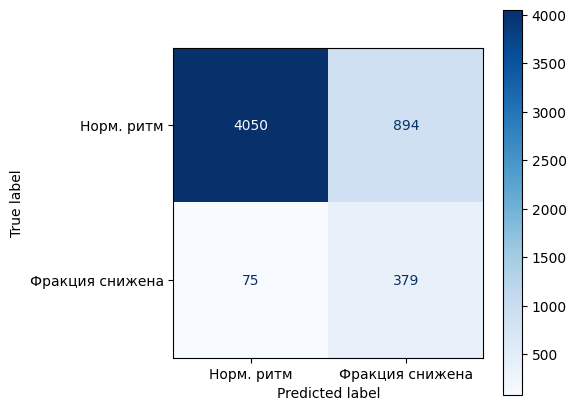

In [80]:
all_preds_21, all_labels_21, itoname_21 = calculate(2, 1, "checkpoints/train_2.pth")

Validation recall: 0.5242
Validation accuracy: 0.7456
Validation precision: 0.9407

 clasification report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79       454
           1       0.94      0.52      0.67       454

    accuracy                           0.75       908
   macro avg       0.81      0.75      0.73       908
weighted avg       0.81      0.75      0.73       908

Матрица несоответствий для тестовой выборки метода ЛДА:



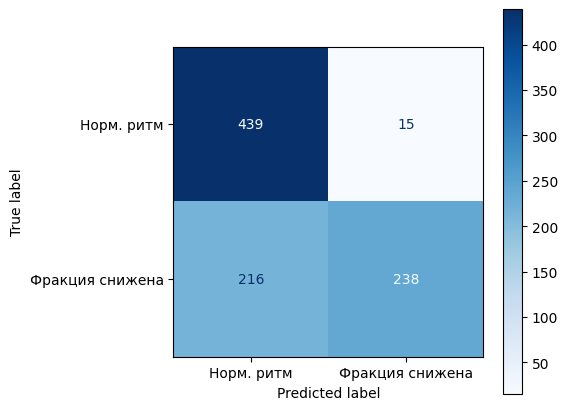

In [81]:
all_preds_12, all_labels_12, itoname_12 = calculate(1, 2, "checkpoints/train_1.pth")

Validation recall: 0.8348
Validation accuracy: 0.8084
Validation precision: 0.7929

 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       454
           1       0.79      0.83      0.81       454

    accuracy                           0.81       908
   macro avg       0.81      0.81      0.81       908
weighted avg       0.81      0.81      0.81       908

Матрица несоответствий для тестовой выборки метода ЛДА:



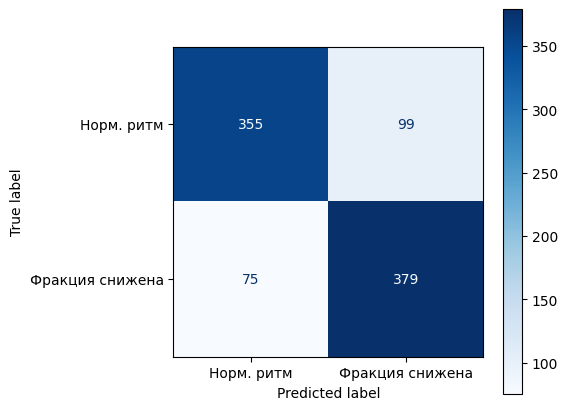

In [82]:
all_preds_22, all_labels_22, itoname_22 = calculate(2, 2, "checkpoints/train_2.pth")

In [102]:
itoname_11_list = [y for x, y in itoname_11.items()][:-1]
itoname_21_list = [y for x, y in itoname_21.items()][:-1]

print(len(all_preds_11))
print(len(all_preds_21))

df11 = pd.DataFrame(
    {
        "Filename": itoname_11_list,
        "label": all_labels_11,
        "Multibranch_predict - train 1": all_preds_11,
    }
)
df21 = pd.DataFrame(
    {
        "Filename": itoname_21_list,
        "label": all_labels_21,
        "Multibranch_predict - train 2": all_preds_21,
    }
)

results_test_1 = df11.merge(df21, on=["Filename", "label"])

5398
5398


In [103]:
results_test_1.head()

,Filename,label,Multibranch_predict - train 1,Multibranch_predict - train 2
0,TG6986.edf,0,0,0
1,TG1776.edf,0,0,0
2,TG8367.edf,0,0,0
3,TG2420.edf,0,0,0
4,TG9493.edf,0,0,0


In [104]:
results_test_1.to_csv("predictions_test_1.csv")

In [105]:
itoname_12_list = [y for x, y in itoname_12.items()][:-1]
itoname_22_list = [y for x, y in itoname_22.items()][:-1]


df12 = pd.DataFrame(
    {
        "Filename": itoname_12_list,
        "label": all_labels_12,
        "Multibranch_predict - train 1": all_preds_12,
    }
)
df22 = pd.DataFrame(
    {
        "Filename": itoname_22_list,
        "label": all_labels_22,
        "Multibranch_predict - train 2": all_preds_22,
    }
)

results_test_2 = df12.merge(df22, on=["Filename", "label"])

In [106]:
results_test_2.head()

,Filename,label,Multibranch_predict - train 1,Multibranch_predict - train 2
0,TG9127.edf,0,0,1
1,TG9076.edf,0,0,0
2,TG778.edf,0,0,1
3,TG10338.edf,0,0,0
4,TG2361.edf,0,0,0


In [107]:
results_test_2.to_csv("predictions_test_2.csv")